torch.Size([200, 1, 28, 28])
torch.Size([200, 1, 28, 28])
torch.Size([200, 1, 28, 28])
torch.Size([200, 1, 28, 28])
torch.Size([200, 1, 28, 28])
torch.Size([200, 1, 28, 28])
torch.Size([200, 1, 28, 28])
torch.Size([200, 1, 28, 28])
torch.Size([200, 1, 28, 28])
torch.Size([200, 1, 28, 28])
torch.Size([200, 1, 28, 28])
torch.Size([200, 1, 28, 28])
torch.Size([200, 1, 28, 28])
torch.Size([200, 1, 28, 28])
torch.Size([200, 1, 28, 28])
torch.Size([200, 1, 28, 28])
torch.Size([200, 1, 28, 28])
torch.Size([200, 1, 28, 28])
torch.Size([200, 1, 28, 28])
torch.Size([200, 1, 28, 28])
torch.Size([200, 1, 28, 28])
torch.Size([200, 1, 28, 28])
torch.Size([200, 1, 28, 28])
torch.Size([200, 1, 28, 28])
torch.Size([200, 1, 28, 28])
torch.Size([200, 1, 28, 28])
torch.Size([200, 1, 28, 28])
torch.Size([200, 1, 28, 28])
torch.Size([200, 1, 28, 28])
torch.Size([200, 1, 28, 28])
torch.Size([200, 1, 28, 28])
torch.Size([200, 1, 28, 28])
torch.Size([200, 1, 28, 28])
torch.Size([200, 1, 28, 28])
torch.Size([20

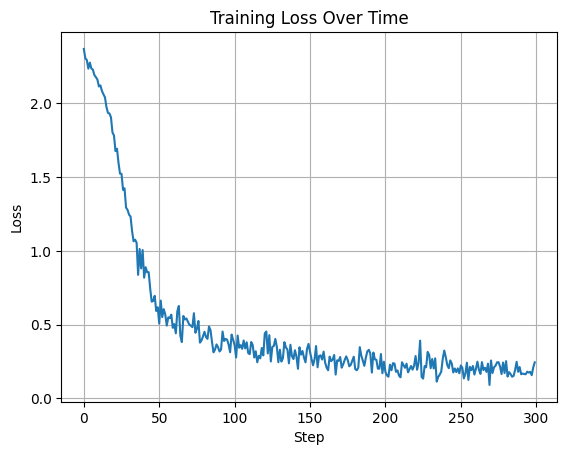

In [1]:
import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
import torchvision.transforms as transforms

## Distributed training
import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP

# # Pennylane
# import pennylane as qml
# from pennylane import numpy as np
import torchquantum as tq
import numpy as np 



torch.manual_seed(42)
np.random.seed(42)

# Plotting
import matplotlib.pyplot as plt


import itertools

# OpenMP: number of parallel threads.
# os.environ["OMP_NUM_THREADS"] = "1"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")



### Classical target model initialization ###

# Hyperparameters
batch_size = 200
learning_rate = 0.001
num_epochs = 1

# Data loading and preprocessing
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(8, 12, kernel_size=5)
        self.fc1 = nn.Linear(12*4*4, 20)
        self.fc2 = nn.Linear(20, 10)
        
    def forward(self, x):
        print(x.size())
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = x.view(x.size(0), -1) # [N, 32 * 8 * 8]
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

# Instantiate the model and loss function
model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
train_steps = []


# Training loop
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Track loss
        train_losses.append(loss.item())
        train_steps.append(epoch * len(train_loader) + i)

        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

# Testing train loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in train_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the train set: {(100 * correct / total):.2f}%")

# Testing loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {(100 * correct / total):.2f}%")


plt.plot(train_steps, train_losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.grid(True)
plt.savefig("training_loss.png", dpi=300)
plt.show()

In [2]:
### required qubits estimation ##############
# NN weights

numpy_weights = {}
nw_list = [] 
nw_list_normal = []
for name, param in model.state_dict().items():
    numpy_weights[name] = param.cpu().numpy()
for i in numpy_weights:
    nw_list.append(list(numpy_weights[i].flatten()))
for i in nw_list:
    for j in i:
        nw_list_normal.append(j)
print("# of NN parameters: ", len(nw_list_normal))
n_qubits = int(np.ceil(np.log2(len(nw_list_normal))))
print("Required qubit number: ", n_qubits)

n_qubit = n_qubits

#############################################

# of NN parameters:  6690
Required qubit number:  13


In [ ]:


### Some tool function definition ###########
def probs_to_weights(probs_):

    new_state_dict = {}
    data_iterator = probs_.view(-1)

    for name, param in CNNModel().state_dict().items():
        shape = param.shape
        num_elements = param.numel()
        chunk = data_iterator[:num_elements].reshape(shape)
        new_state_dict[name] = chunk
        data_iterator = data_iterator[num_elements:]
        
    return new_state_dict

def generate_qubit_states_torch(n_qubit):
    # Create a tensor of shape (2**n_qubit, n_qubit) with all possible combinations of 0 and 1
    all_states = torch.cartesian_prod(*[torch.tensor([-1, 1]) for _ in range(n_qubit)])
    return all_states

#############################################

### Main Learning-wise Hybridization model ##

class LewHybridNN(nn.Module):
    class QLayer(nn.Module):
        def __init__(self, n_blocks):
            super().__init__()
            self.n_wires = int(np.ceil(np.log2(len(nw_list_normal)))),
            self.n_wires = self.n_wires[0]
            self.n_blocks = n_blocks
            self.u3_layers = tq.QuantumModuleList()
            self.cu3_layers = tq.QuantumModuleList()
            # self.measure = tq.MeasureAll(tq.PauliZ)
            for _ in range(self.n_blocks):
                self.u3_layers.append(
                    tq.Op1QAllLayer(
                        op=tq.U3,
                        n_wires=self.n_wires,
                        has_params=True,
                        trainable=True,
                    )
                )
                self.cu3_layers.append(
                    tq.Op2QAllLayer(
                        op=tq.CU3,
                        n_wires=self.n_wires,
                        has_params=True,
                        trainable=True,
                        circular=True,
                    )
                )
                
        def forward(self):
            qdev = tq.QuantumDevice(
                n_wires=self.n_wires, bsz=1, device=next(self.parameters()).device
            )
            easy_scale_coeff = 2**(n_qubit-1)
            gamma = 0.1
            beta  = 0.8
            alpha = 0.3
            for k in range(self.n_blocks):
                self.u3_layers[k](qdev)
                self.cu3_layers[k](qdev)
                
            state_mag = qdev.get_states_1d().abs()[0] 
            state_mag = state_mag[:len(nw_list_normal)]
            x = torch.abs(state_mag) ** 2

            state_mag = state_mag[:len(nw_list_normal)]
            x = torch.abs(state_mag) ** 2
            # x = torch.log(x)
            x = x.reshape(len(nw_list_normal),1)
            x = (beta*torch.tanh(gamma*easy_scale_coeff*x))**(alpha) 
            x = x - torch.mean(x)
            x.to(device)
            return x

    def train_with_shots(shots, epochs=1):
    model = LewHybridNN(shots=shots).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=step, weight_decay=1e-5, eps=1e-6)

    acc_list = []

    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            labels_one_hot = F.one_hot(labels, num_classes=10).float()

            loss = criterion(outputs, labels_one_hot)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        acc = 100 * correct / total
        acc_list.append(acc)
        print(f"[Shots={shots}] Epoch {epoch+1}: Accuracy = {acc:.2f}%")

    return acc_list[-1]

        
    class MappingModel(nn.Module):
        def __init__(self, input_size, hidden_sizes, output_size):
            super().__init__()
            # Initialize layers: an input layer, multiple hidden layers, and an output layer
            self.input_layer = nn.Linear(input_size, hidden_sizes[0])
            self.hidden_layers = nn.ModuleList([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]) for i in range(len(hidden_sizes)-1)])
            self.output_layer = nn.Linear(hidden_sizes[-1], output_size)
            
        def forward(self, X):
            # Ensure the input tensor is the same type as the weights
            X = X.type_as(self.input_layer.weight)

            # Input layer with ReLU activation
            X = self.input_layer(X)

            # Hidden layers with ReLU activation
            for hidden in self.hidden_layers:
                X = hidden(X)

            # Output layer with linear activation
            output = self.output_layer(X)
            # output = F.tanh(output)  # It's often better to use ReLU or similar; tanh is used here as it was in the original model.
            return output

    def __init__(self, shots=8192):  # ← allow external config
    super().__init__()
    self.MappingNetwork = self.MappingModel(n_qubit + 1, [4, 20, 4], 1).to(device)
    self.QuantumNN = self.QLayer(q_depth, shots=shots).to(device)  # ← pass shots in

    
    def forward(self, x):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """
        device = x.device

        probs_ = self.QuantumNN()
        probs_ = probs_[:len(nw_list_normal)]
        
        # Generate qubit states using PyTorch
        qubit_states_torch = generate_qubit_states_torch(n_qubit)[:len(nw_list_normal)]
        qubit_states_torch = qubit_states_torch.to(device)

        # Combine qubit states with probability values using PyTorch
        combined_data_torch = torch.cat((qubit_states_torch, probs_), dim=1)
        combined_data_torch = combined_data_torch.reshape(len(nw_list_normal), 1, n_qubit+1)
        
        prob_val_post_processed = self.MappingNetwork(combined_data_torch)
        prob_val_post_processed = prob_val_post_processed - prob_val_post_processed.mean()
        
        state_dict = probs_to_weights(prob_val_post_processed)

        ######## 
            
        dtype = torch.float32  # Ensure all tensors are of this type
        
        # Convolution layer 1 parameters
        conv1_weight = state_dict['conv1.weight'].to(device).type(dtype)
        conv1_bias = state_dict['conv1.bias'].to(device).type(dtype)

        # Convolution layer 2 parameters
        conv2_weight = state_dict['conv2.weight'].to(device).type(dtype)
        conv2_bias = state_dict['conv2.bias'].to(device).type(dtype)

        # Fully connected layer 1 parameters
        fc1_weight = state_dict['fc1.weight'].to(device).type(dtype)
        fc1_bias = state_dict['fc1.bias'].to(device).type(dtype)

        # Fully connected layer 2 parameters
        fc2_weight = state_dict['fc2.weight'].to(device).type(dtype)
        fc2_bias = state_dict['fc2.bias'].to(device).type(dtype)
        
        
        # Convolution 1
        x = F.conv2d(x, conv1_weight, conv1_bias, stride=1)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Convolution 2
        x = F.conv2d(x, conv2_weight, conv2_bias, stride=1)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected 1
        x = F.linear(x, fc1_weight, fc1_bias)

        # Fully connected 2
        x = F.linear(x, fc2_weight, fc2_bias)

    
        return x 

In [4]:

### Training setting ########################

step = 1e-4                 # Learning rate
batch_size = 32       # Number of samples for each training step
num_epochs = 5             # Number of training epochs
q_depth = 4             # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.1              # Initial spread of random quantum weights

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)



# Instantiate the model, move it to GPU, and set up loss function and optimizer
model = LewHybridNN().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=step, weight_decay=1e-5, eps=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, factor = 0.5)  # 'min' because we're minimizing loss

num_trainable_params_MM = sum(p.numel() for p in LewHybridNN.MappingModel(n_qubit+1,  [4, 20, 4], 1).parameters() if p.requires_grad)
# num_trainable_params_MM = sum(p.numel() for p in LewHybridNN.ConvMappingModel().parameters() if p.requires_grad)
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("# of trainable parameter in Mapping model: ", num_trainable_params_MM)
print("# of trainable parameter in QNN model: ", num_trainable_params - num_trainable_params_MM)
print("# of trainable parameter in full model: ", num_trainable_params)


# of trainable parameter in Mapping model:  249
# of trainable parameter in QNN model:  312
# of trainable parameter in full model:  561


In [5]:


#############################################
### Training loop ###########################

### (Optional) Start from pretrained model ##
# model = torch.load('result_FF_mm_b1000_40_200_40/tq_mm_acc_70_bsf')
# model.eval()  # Set the model to evaluation mode
#############################################

loss_list = [] 
acc_list = [] 
acc_best = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0   # ← moved here
    total = 0     # ← moved here

    for i, (images, labels) in enumerate(train_loader):
        since_batch = time.time()
        
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(images)
        labels_one_hot = F.one_hot(labels, num_classes=10).float()

        # Compute loss
        loss = criterion(outputs, labels_one_hot)

        # Track loss
        loss_list.append(loss.cpu().detach().numpy())
        train_loss += loss.item()

        # Track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Backward and optimize
        loss.backward()
        optimizer.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}, batch time: {time.time() - since_batch:.2f}")

    # 🔵 End of epoch
    acc = 100 * correct / total
    acc_list.append(acc)
    train_loss /= len(train_loader)
    scheduler.step(train_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] Accuracy: {acc:.2f}%")

    # Save best model
    if acc > acc_best:
        torch.save(model, 'L16/tq_mm_acc_' + str(int(acc)) + '_bsf')
        acc_best = acc

# 📝 Save logs
# np.save("loss_train_list.npy", loss_list)
# np.save("acc_train_list.npy", acc_list)

    
#############################################

Epoch [1/5], Step [1/1875], Loss: 59.1729, batch time: 1.68
Epoch [1/5], Step [2/1875], Loss: 62.1174, batch time: 0.11
Epoch [1/5], Step [3/1875], Loss: 58.3071, batch time: 0.13
Epoch [1/5], Step [4/1875], Loss: 50.4235, batch time: 0.10
Epoch [1/5], Step [5/1875], Loss: 38.0613, batch time: 0.13
Epoch [1/5], Step [6/1875], Loss: 49.6909, batch time: 0.12
Epoch [1/5], Step [7/1875], Loss: 51.6529, batch time: 0.13
Epoch [1/5], Step [8/1875], Loss: 42.9288, batch time: 0.18
Epoch [1/5], Step [9/1875], Loss: 44.1946, batch time: 0.11
Epoch [1/5], Step [10/1875], Loss: 39.4623, batch time: 0.12
Epoch [1/5], Step [11/1875], Loss: 46.2461, batch time: 0.14
Epoch [1/5], Step [12/1875], Loss: 44.4344, batch time: 0.12
Epoch [1/5], Step [13/1875], Loss: 36.4923, batch time: 0.12
Epoch [1/5], Step [14/1875], Loss: 32.1761, batch time: 0.11
Epoch [1/5], Step [15/1875], Loss: 37.4950, batch time: 0.19
Epoch [1/5], Step [16/1875], Loss: 34.1649, batch time: 0.10
Epoch [1/5], Step [17/1875], Loss

In [6]:

# step = 1e-2                # Learning rate
# batch_size = 64       # Number of samples for each training step
# num_epochs = 1             # Number of training epochs
# q_depth = 13             # Depth of the quantum circuit (number of variational layers)
# gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
# q_delta = 0.1              # Initial spread of random quantum weights

# train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)



# #############################################
# ### Training loop ###########################

# ### (Optional) Start from pretrained model ##
# # model = torch.load('result_FF_mm_b1000_40_200_40/tq_mm_acc_70_bsf')
# # model.eval()  # Set the model to evaluation mode
# #############################################

# loss_list = [] 
# acc_list = [] 
# acc_best = 0
# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0
#     for i, (images, labels) in enumerate(train_loader):
#         correct = 0
#         total = 0
#         since_batch = time.time()
        
#         images, labels = images.to(device), labels.to(device)  # Move data to GPU
#         optimizer.zero_grad()
#         # Forward pass
#         outputs = model(images)
#         # print("output: ", outputs)
#         labels_one_hot = F.one_hot(labels, num_classes=10).float()
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
#         # Compute loss
#         loss = criterion(outputs, labels_one_hot)
#         # log_loss = torch.log(loss + 1e-6)
        
#         loss_list.append(loss.cpu().detach().numpy())
#         acc = 100 * correct / total
#         acc_list.append(acc)
#         train_loss += loss.cpu().detach().numpy()
        
#         # np.array(loss_list).dump("result_FF_mm_L38_b1000_40_200_40/loss_list.dat")
#         # np.array(acc_list).dump("result_FF_mm_L38_b1000_40_200_40/acc_list.dat")
#         if acc > acc_best:
#             # torch.save(model, 'result_FF_mm_L38_b1000_40_200_40/tq_mm_acc_'+str(int(acc))+'_bsf')
#             acc_best = acc
#         # Backward pass and optimization
#         loss.backward()
        
#         optimizer.step()
#         # if (i+1) % 100 == 0:
#         print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}, batch time: {time.time() - since_batch:.2f}, accuracy:  {(acc):.2f}%")
    
#     train_loss /= len(train_loader)
#     scheduler.step(train_loss)
    
# #############################################

In [7]:
from torch.utils.data import DataLoader, random_split




In [8]:
# Testing train loop
model.eval()
correct = 0
total = 0
loss_train_list = []
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        outputs = model(images)
        loss_train = criterion(outputs, labels).cpu().detach().numpy()
        loss_train_list.append(loss_train)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the train set: {(100 * correct / total):.2f}%")
print(f"Loss on the train set: {np.mean(loss_train_list):.2f}")


Accuracy on the train set: 37.36%
Loss on the train set: 1.79


In [9]:

test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Assuming testset is your original test dataset
test_size = int(len(test_dataset) * 0.1)  # 80% of the original testset size
validation_size = len(test_dataset) - test_size  # The remaining 20% for validation

# Split the testset into new testset and validation set
new_testset, validationset = random_split(test_dataset, [test_size, validation_size])

# Create DataLoader for the new testset and validation set
new_testloader = DataLoader(new_testset, batch_size=64, shuffle=True)
validationloader = DataLoader(validationset, batch_size=64, shuffle=True)



# Testing loop
model.eval()
correct = 0
total = 0
loss_test_list = []

with torch.no_grad():
    for images, labels in new_testloader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        outputs = model(images)
        loss_test = criterion(outputs, labels).cpu().detach().numpy()
        loss_test_list.append(loss_test)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


print(f"Accuracy on the test set: {(100 * correct / total):.2f}%")
print(f"Loss on the test set: {np.mean(loss_test_list):.2f}")

print("Generalization error:", np.mean(loss_test_list) - np.mean(loss_train_list))



Accuracy on the test set: 37.10%
Loss on the test set: 1.80
Generalization error: 0.006307721


In [10]:
import numpy as np

# Save training metrics
np.save("loss_train_list_q.npy", loss_list)
np.save("acc_train_list_q.npy", acc_list)
print("Saved loss_train_list.npy and acc_train_list.npy")


Saved loss_train_list.npy and acc_train_list.npy


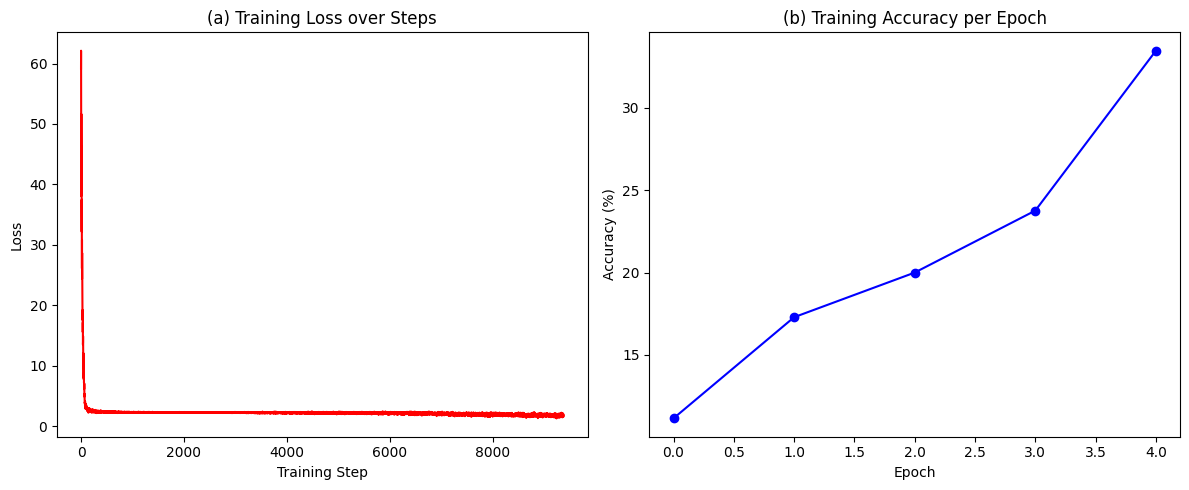

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Load saved metrics
loss_train_list = np.load("loss_train_list_q.npy")
acc_train_list = np.load("acc_train_list_q.npy")

steps = range(len(loss_list))
epochs = range(len(acc_list))

plt.figure(figsize=(12, 5))

# Plot (a) Training loss
plt.subplot(1, 2, 1)
plt.plot(steps, loss_train_list, color='red')
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("(a) Training Loss over Steps")

# Plot (b) Accuracy per epoch
plt.subplot(1, 2, 2)
plt.plot(epochs, acc_train_list, marker='o', color='blue')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("(b) Training Accuracy per Epoch")

plt.tight_layout()
plt.savefig("training_metrics_quantum.png", dpi=300)
plt.show()
